## Rivers measured discharge and seasonal cycle

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
import numpy as np
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import glob

import sys
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/VIZ')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
#import mocsy
import river_201702 as rv
import VIZ_plots as VP

from importlib import reload
from salishsea_tools import viz_tools

%matplotlib inline
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 13,
                     'xtick.labelsize' : 13,
                     'ytick.labelsize' : 13})

In [4]:
#useful river name info, watershed info, watershed colour code info
us_nam = ['Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene','Duckabush','Skokomish',\
          'Skokomish2','DeerJohnsGoldboroughMill','Deschutes','Chambers','NisquallyMcAllister',\
          'Puyallup','CedarSammamish','Skagit1','Samish','Stillaguamish1','SnohomishAllenQuilceda',\
          'Tulalip','Mission','Nooksack']
can_nam = ['Squamish', 'SanJuan', 'Oyster', 'Quinsam', 'SalmonSayward', 'Theodosia',\
      'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman','LittleQualicum']

all_nam = ['Elwha','DungenessMatriotti','Hoko','LittleBigQuilcene','Duckabush','Skokomish',\
          'Skokomish2','DeerJohnsGoldboroughMill','Deschutes','Chambers','NisquallyMcAllister',\
          'Puyallup','CedarSammamish','Skagit1','Samish','Stillaguamish1','SnohomishAllenQuilceda',\
          'Tulalip','Mission','Nooksack','Squamish', 'SanJuan', 'Oyster', 'Quinsam',\
           'SalmonSayward','Theodosia', 'Homathko','Cowichan1','Chemanius1','Nanaimo1','Englishman','LittleQualicum']
watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
cols = ['darkgray','red','powderblue','tan','orange',\
    'navy','palegreen','mediumaquamarine','dodgerblue','violet']


cols2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#911eb4',\
        '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',\
         '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']


In [5]:
#load metadata about rivers, their data source (us or can), and watershed
meta_csv = './rivers_discharge/rivers_meta.csv'
import pandas as pd
colnames = ['River','DataSrc','SiteNo','Watershed','Firstyear']
riv_meta = pd.read_csv(meta_csv, names=colnames)
riv_meta['River'][24] = 'Quinsam'
#sample code to find the watershed of a given river in the metafile
q = riv_meta.loc[riv_meta.River == 'Squamish',['Watershed']].values

#sample code to show top of metafile
riv_meta.head()

River  DataSrc    SiteNo  Watershed   Firstyear
0               River  DataSrc    SiteNo  Watershed   Firstyear
1            Squamish        C   08GA022       howe  1922-11-24
2             SanJuan        C   08HA010        jdf  1959-10-11
3               Elwha        U  12045500        jdf  1897-10-01
4  DungenessMatriotti        U  12048000        jdf  1923-06-01

In [6]:
#code to find the locations of csvs with discharge data
can_csv = []
us_csv = []
for i in range(0,33):   
    dsrc = riv_meta['DataSrc'][i]
    if dsrc == 'C':
        #print(riv_meta['River'][i])
        t_text = './rivers_discharge/rivers_EChead/' + riv_meta['River'][i] +'*'
        w = glob.glob(t_text)
        w2 = w[0]
        can_csv.append(w2)
    if dsrc == 'U':
        #print(riv_meta['River'][i])
        t_text = './rivers_discharge/rivers_USGS_head/' + riv_meta['River'][i] +'*.csv'
        w = glob.glob(t_text)
        w2 = w[0]
        us_csv.append(w2)
    

In [7]:
#load csvs into a dictionary of dfs
can_dfs = {}
colnames = ['ID','PARAM','Date','Value']
for df, file in zip(can_nam, can_csv):
    can_dfs[df] = pd.read_csv(file, delimiter=',')

    
colnames = ['agency_cd','site_no','datetime','disc']

us_dfs = {}
for df, file in zip(us_nam, us_csv):
    us_dfs[df] = pd.read_csv(file, delimiter=',')  

    
    

In [8]:
#use a river name key to recover times (list of datetimes) and discharges (np array) from a dict of dataframes
def extract_dates_disc_US(rivname):
    #also converts from cubic feet of discharge to cubic meters

    listdates = us_dfs[rivname]['date'].tolist()
    #just take YMD format - sdates = shortdates
    sdates = []
    for el in listdates:
        el = (el[:10])
        sdates.append(el)
    #datetime format for dates
    tdate = [dt.datetime.strptime(x,'%Y-%m-%d') for x in sdates]

    tdisc = us_dfs[rivname]['disc'].values
    tdisc_met = tdisc * 0.0283168
    return tdate, tdisc_met

def extract_dates_disc_CAN(rivname):
    listdates = can_dfs[rivname]['Date'].tolist()
    tdate = [dt.datetime.strptime(x,'%Y/%m/%d') for x in listdates]
    tdisc = can_dfs[rivname]['Value'].values
    return tdate, tdisc
    

## [A]  Measured discharge for all gauged rivers, by watershed (Fraser not included)

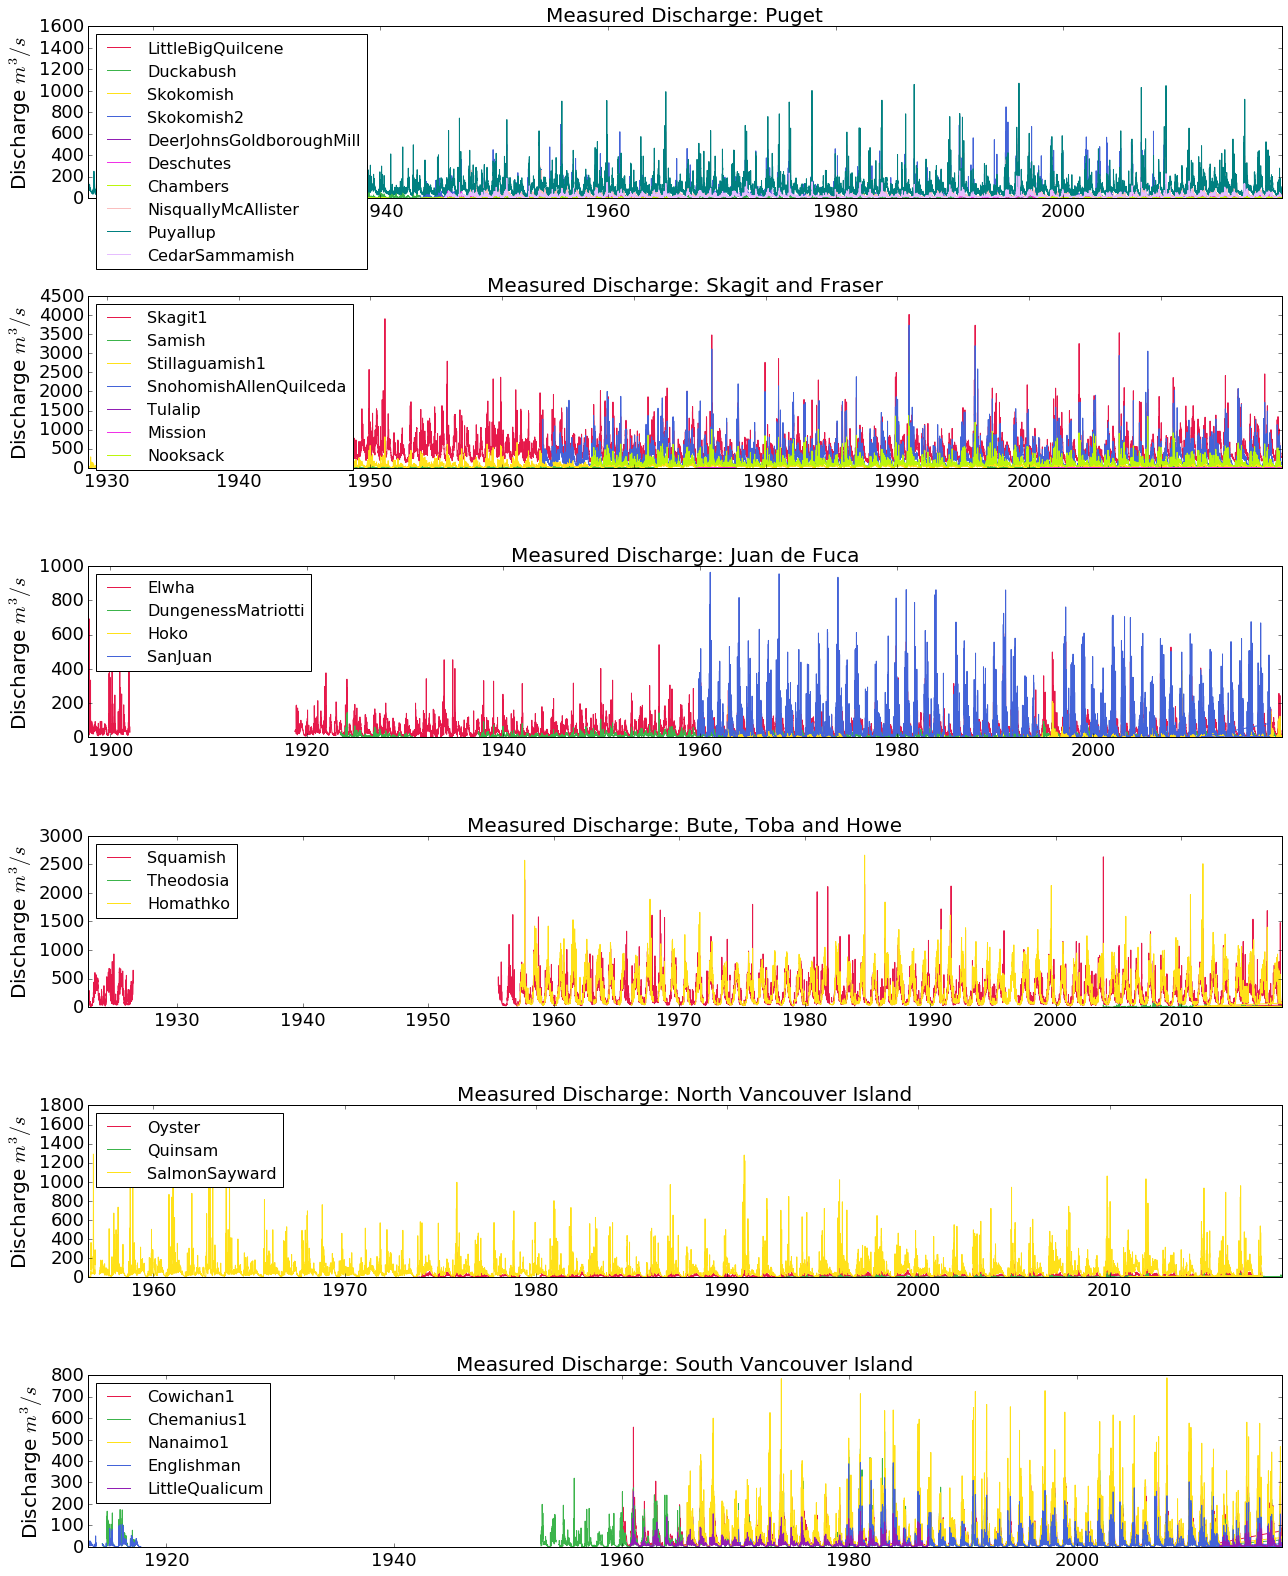

In [9]:
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,22))

for i in range(1,7):
    ax = fig.add_subplot(6,1,i)

    #puget
    if i == 1:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'puget':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Puget", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        
    #skagit and fraser
    if i == 2:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'skagit':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
            if twat == 'fraser':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Skagit and Fraser", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)  

    #jdf
    if i == 3:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'jdf':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Juan de Fuca", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    
    #canadian coast
    if i == 4:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'bute':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                    
            if twat == 'toba':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                    
            if twat == 'howe':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Bute, Toba and Howe", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    
    #evi n
    if i == 5:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'evi_n':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: North Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18) 
    #evi s
    if i == 6:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'evi_s':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: South Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)


    #plt.legend(bbox_to_anchor=(1.1, 1.96))

#plt.savefig('TS_locmag.jpg')
fig.tight_layout()  
#plt.show()

## [B] Measured discharge - normalized timeseries lengths and magnitudes

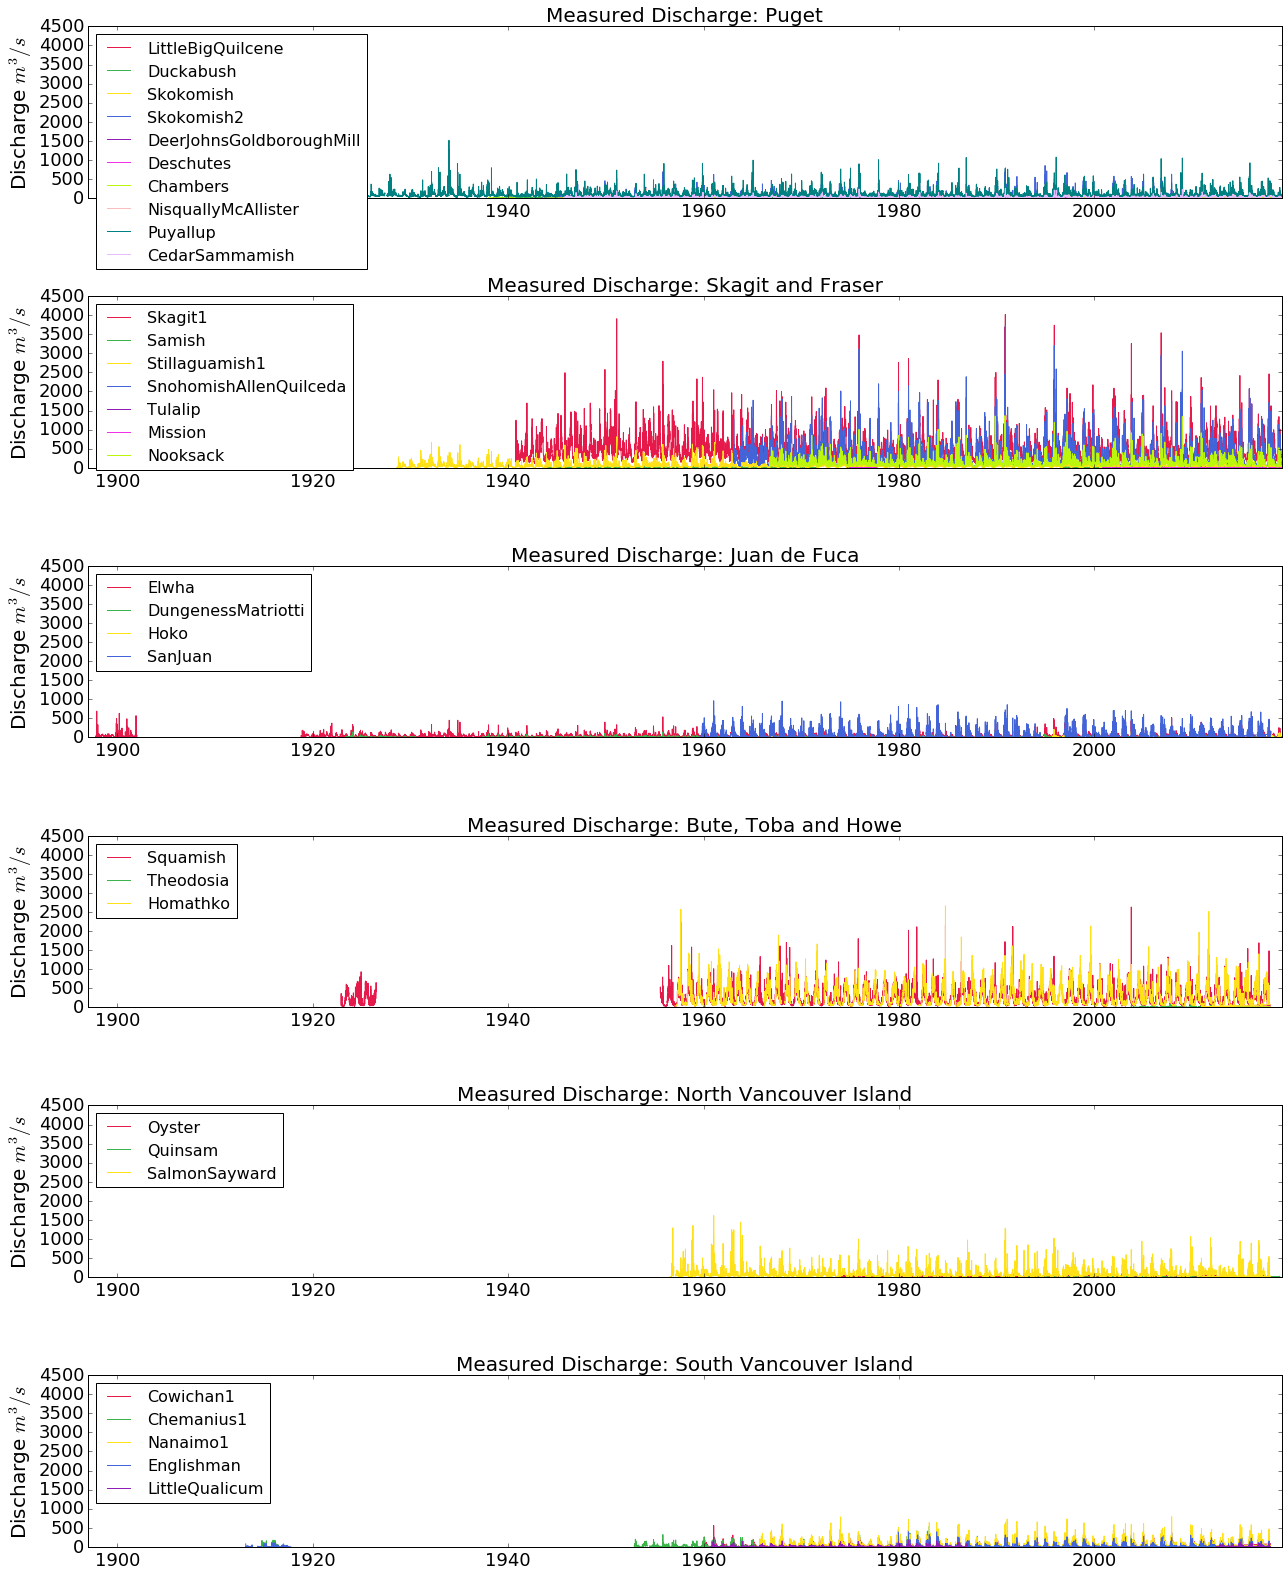

In [10]:
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,22))

for i in range(1,7):
    ax = fig.add_subplot(6,1,i)


    #puget
    if i == 1:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'puget':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Puget", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([dt.date(1897, 1, 1), dt.date(2019, 3, 8)])
        ax.set_ylim([0, 4500])

        
    #skagit and fraser
    if i == 2:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'skagit':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
            if twat == 'fraser':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Skagit and Fraser", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)  
        ax.set_xlim([dt.date(1897, 1, 1), dt.date(2019, 3, 8)])
        ax.set_ylim([0, 4500])
    #jdf
    if i == 3:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'jdf':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Juan de Fuca", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

        ax.set_xlim([dt.date(1897, 1, 1), dt.date(2019, 3, 8)])
        ax.set_ylim([0, 4500])
    #canadian coast
    if i == 4:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'bute':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                    
            if twat == 'toba':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                    
            if twat == 'howe':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: Bute, Toba and Howe", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([dt.date(1897, 1, 1), dt.date(2019, 3, 8)])
        ax.set_ylim([0, 4500])    
    #evi n
    if i == 5:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'evi_n':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: North Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18) 
        ax.set_xlim([dt.date(1897, 1, 1), dt.date(2019, 3, 8)])
        ax.set_ylim([0, 4500])
        #evi s
    if i == 6:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            tsrc = riv_meta.loc[riv_meta.River == all_nam[r],['DataSrc']].values
            if twat == 'evi_s':
                tnam = (all_nam[r])
                if tsrc == 'U':
                    tdate, tdisk = extract_dates_disc_US(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
                if tsrc == 'C':
                    tdate, tdisk = extract_dates_disc_CAN(tnam)
                    ax.plot(tdate, tdisk, label = tnam,color=cols2[colcount])
                    colcount = colcount+1
        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Measured Discharge: South Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Year', fontsize=20)
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([dt.date(1897, 1, 1), dt.date(2019, 3, 8)])
        ax.set_ylim([0, 4500])

    #plt.legend(bbox_to_anchor=(1.1, 1.96))

#plt.savefig('TS_unifmag.jpg')
fig.tight_layout()  
#plt.show()

In [11]:
rivs_with_hist = []
for name in zip(all_nam):
    nam2 = (name[0])
    #print(nam2)
    tsrc = riv_meta.loc[riv_meta.River == nam2,['DataSrc']].values
    #print(tsrc)
    if tsrc == 'C':
        tdate, tdisk = extract_dates_disc_CAN(nam2)
    if tsrc == 'U':
        tdate, tdisk = extract_dates_disc_US(nam2)
    edate = dt.datetime(1962,1,1)
    edate2 = dt.datetime(1967,1,1)
    ldate = dt.datetime(2012,1,1)
    ldate2 = dt.datetime(2017,1,1)
    
    #print(nam2)
    hist = ((edate in tdate) & (edate2 in tdate) & (ldate in tdate) & (ldate2 in tdate))
    #print(hist)
    if hist == True:
        rivs_with_hist.append(nam2)
        


In [12]:
edate = dt.datetime(1962,1,1)
edate2 = dt.datetime(1967,1,1)

ldate = dt.datetime(2012,1,1)
ldate2 = dt.datetime(2017,1,1)

riv_yearlys1962 = {}
riv_yearlys2012 = {}
for name in zip(rivs_with_hist):
    nam2 = (name[0])

    tsrc = riv_meta.loc[riv_meta.River == nam2,['DataSrc']].values
    #print(tsrc)
    if tsrc == 'C':
        tdate, tdisk = extract_dates_disc_CAN(nam2)
    if tsrc == 'U':
        tdate, tdisk = extract_dates_disc_US(nam2)
    av_cycle_e = np.zeros([1,366])
    av_counter_e = np.zeros([1,366])
    tins = tdate.index(edate)
    tine = tdate.index(edate2)
    for i in range(tins,tine):
        trial = tdate[i]
        doy = trial.timetuple().tm_yday
        if ~(np.isnan(tdisk[i])):
            av_cycle_e[0,doy-1] = av_cycle_e[0,doy-1] + tdisk[i]
            av_counter_e[0,doy-1] = av_counter_e[0,doy-1]+1

    av_counter_e[av_counter_e == 0] = 1
    fin_cycle_e = av_cycle_e/av_counter_e
    fin_cycle2_e = np.squeeze(fin_cycle_e)
    riv_yearlys1962[nam2] = fin_cycle2_e

print(' ')
for name in zip(rivs_with_hist):
    nam2 = (name[0])

    tsrc = riv_meta.loc[riv_meta.River == nam2,['DataSrc']].values
    #print(tsrc)
    if tsrc == 'C':
        tdate, tdisk = extract_dates_disc_CAN(nam2)
    if tsrc == 'U':
        tdate, tdisk = extract_dates_disc_US(nam2)    
    av_cycle_l = np.zeros([1,366])
    av_counter_l = np.zeros([1,366])
    tins = tdate.index(ldate)
    tine = tdate.index(ldate2)
    for i in range(tins,tine):
        trial = tdate[i]
        doy = trial.timetuple().tm_yday
        if ~(np.isnan(tdisk[i])):
            av_cycle_l[0,doy-1] = av_cycle_l[0,doy-1] + tdisk[i]
            av_counter_l[0,doy-1] = av_counter_l[0,doy-1]+1
    av_counter_l[av_counter_l == 0] = 1
    fin_cycle_l = av_cycle_l/av_counter_l
    fin_cycle2_l = np.squeeze(fin_cycle_l)
    riv_yearlys2012[nam2] = fin_cycle2_l

    
    
print(' ')
riv_yearlys = {}

for name in zip(all_nam):
    nam2 = (name[0])
    #print(nam2)
    tsrc = riv_meta.loc[riv_meta.River == nam2,['DataSrc']].values
    #print(tsrc)
    if tsrc == 'C':
        tdate, tdisk = extract_dates_disc_CAN(nam2)
    if tsrc == 'U':
        tdate, tdisk = extract_dates_disc_US(nam2)
    av_cycle = np.zeros([1,366])
    av_counter = np.zeros([1,366])
    for i in range(0,len(tdate)):
        trial = tdate[i]
        doy = trial.timetuple().tm_yday
        if ~(np.isnan(tdisk[i])):
            av_cycle[0,doy-1] = av_cycle[0,doy-1] + tdisk[i]
            av_counter[0,doy-1] = av_counter[0,doy-1]+1
    av_counter[av_counter == 0] = 1
    fin_cycle = av_cycle/av_counter
    fin_cycle2 = np.squeeze(fin_cycle)
    riv_yearlys[nam2] = fin_cycle2
    

## [C] Mean yearly cycles of gauged rivers by watershed

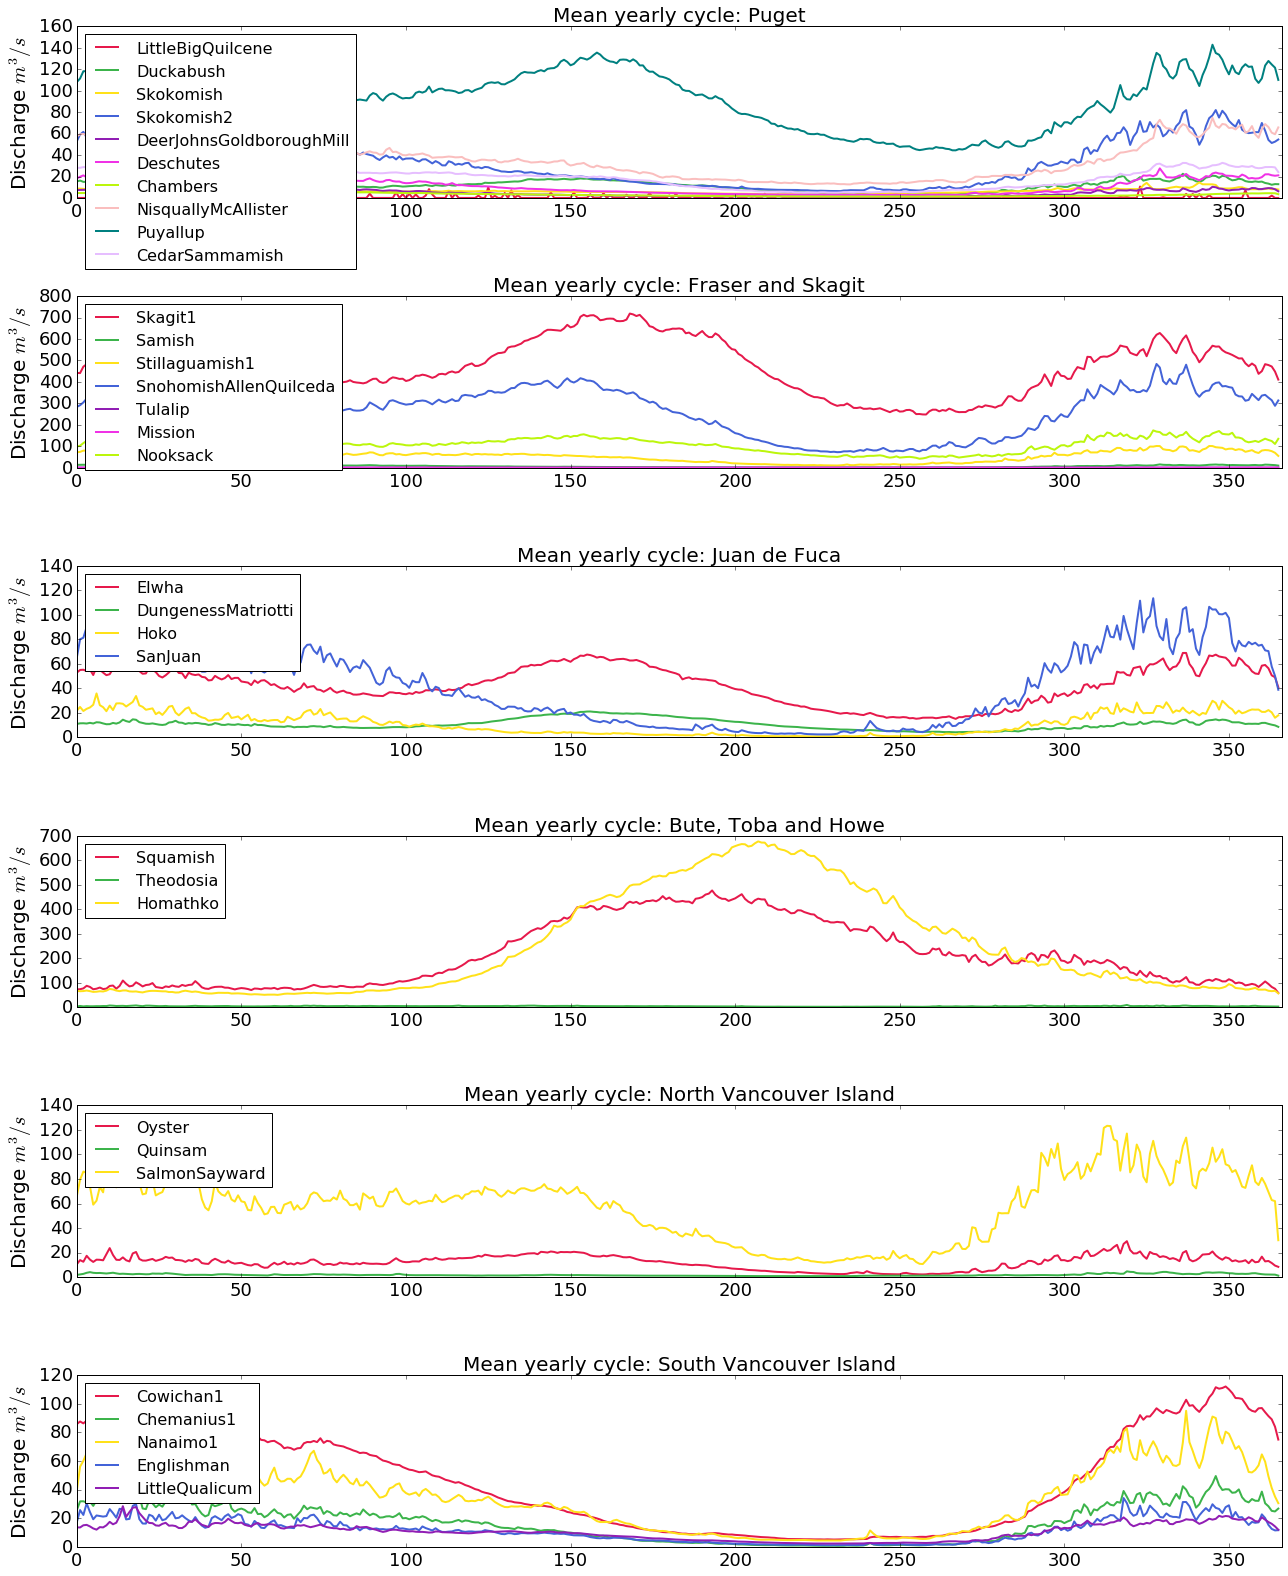

In [13]:
yearly = np.arange(0,366,1)
#code for mean yearly cycles
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,22))

for i in range(1,7):
    ax = fig.add_subplot(6,1,i)


    #puget
    if i == 1:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if twat == 'puget':
                tnam = (all_nam[r])
                tdisk = riv_yearlys[tnam]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Puget", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])

    if i == 2:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'fraser') | (twat == 'skagit')):
                tnam = (all_nam[r])
                tdisk = riv_yearlys[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Fraser and Skagit", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])        

    if i ==3:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'jdf')):
                tnam = (all_nam[r])
                tdisk = riv_yearlys[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Juan de Fuca", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])          

    if i ==4:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'bute') | (twat == 'toba') | (twat == 'howe')):
                tnam = (all_nam[r])
                tdisk = riv_yearlys[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Bute, Toba and Howe", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])   

    if i ==5:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'evi_n')):
                tnam = (all_nam[r])
                tdisk = riv_yearlys[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: North Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366]) 
        
    if i ==6:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'evi_s')):
                tnam = (all_nam[r])
                tdisk = riv_yearlys[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: South Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366]) 
    #plt.legend(bbox_to_anchor=(1.1, 1.96))

plt.savefig('yearlycycle.jpg')
fig.tight_layout()  
#plt.show()

## [D] this code converts the non-intuitive mode of dealing with rivers 'as rain', to m3/s
#### enables conversion with gauges

In [14]:
daylist = [31,29,31,30,31,30,31,31,30,31,30,31]
# mons=[]
mons=np.zeros([1,12])
for i in range(1,12):
    mons[0,i]=sum(daylist[0:i])
    

mons = mons[0]


watersheds = rv.prop_dict.keys()
riv_i = []
riv_j = []
riv_shed = []
riv_name = []
i = 0
for watshed in watersheds:
    #print('~~')
    rivs = rv.prop_dict[watshed].keys()
    for riv in rivs:
        #print('Riv: '+riv+', watershed: '+watshed)
        #swap is, js here
        ti = rv.prop_dict[watshed][riv]['j']
        tj = rv.prop_dict[watshed][riv]['i']
        riv_i.append(ti)
        riv_j.append(tj)
        riv_shed.append(watshed)
        riv_name.append(riv)
        i = i+1
        
tdir = '/data/tjarniko/results/BASERUN_EXP/MAIN/BR_3rd_2015/ncs/'
tnc0 = 'SKOG_1d_20151127_20151231_grid_T_20151208-20151208.nc'
tnc = nc.Dataset(tdir + tnc0)
runoff_table = np.zeros([171,12])
rivdat = nc.Dataset('/data/tjarniko/MEOPAR/rivers/rivers_month_201702.nc')
t_runoff = rivdat.variables['rorunoff']
riv_runoff_mod = {}
riv_id = {}
riv_jd = {}
riv_runoff_m3 = {}

#print(t_runoff.shape)
w = 90
#print(t_runoff[:,riv_j[w],riv_i[w]])

for r in range(0,len(riv_i)):
    
    #print(riv_name[r])
    ti = riv_i[r]
    #print(ti)
    tj = riv_j[r]
    runoff = t_runoff[:,tj,ti]
    year_runoff = np.zeros([1,366])
    year_runoff = np.squeeze(year_runoff)
    runoff_table[r,:]= runoff
    #print(runoff)
    riv_id[riv_name[r]] = ti
    riv_jd[riv_name[r]] = tj
    for i in range (0,11):
        st = int((mons[i]))
        en = int((mons[i+1]))

        year_runoff[st:en] = runoff[i]
    year_runoff[int(mons[11]):366] = runoff[11]
    riv_runoff_mod[riv_name[r]] = year_runoff
#     print(runoff)
    t_area = (tnc.variables['area'][tj,ti])
    
#     print(year_runoff)
    year_runoff2 = (year_runoff / 1000) * t_area
#     print(year_runoff) 
    riv_runoff_m3[riv_name[r]] = year_runoff2

Oyster
Quinsam
SalmonSayward


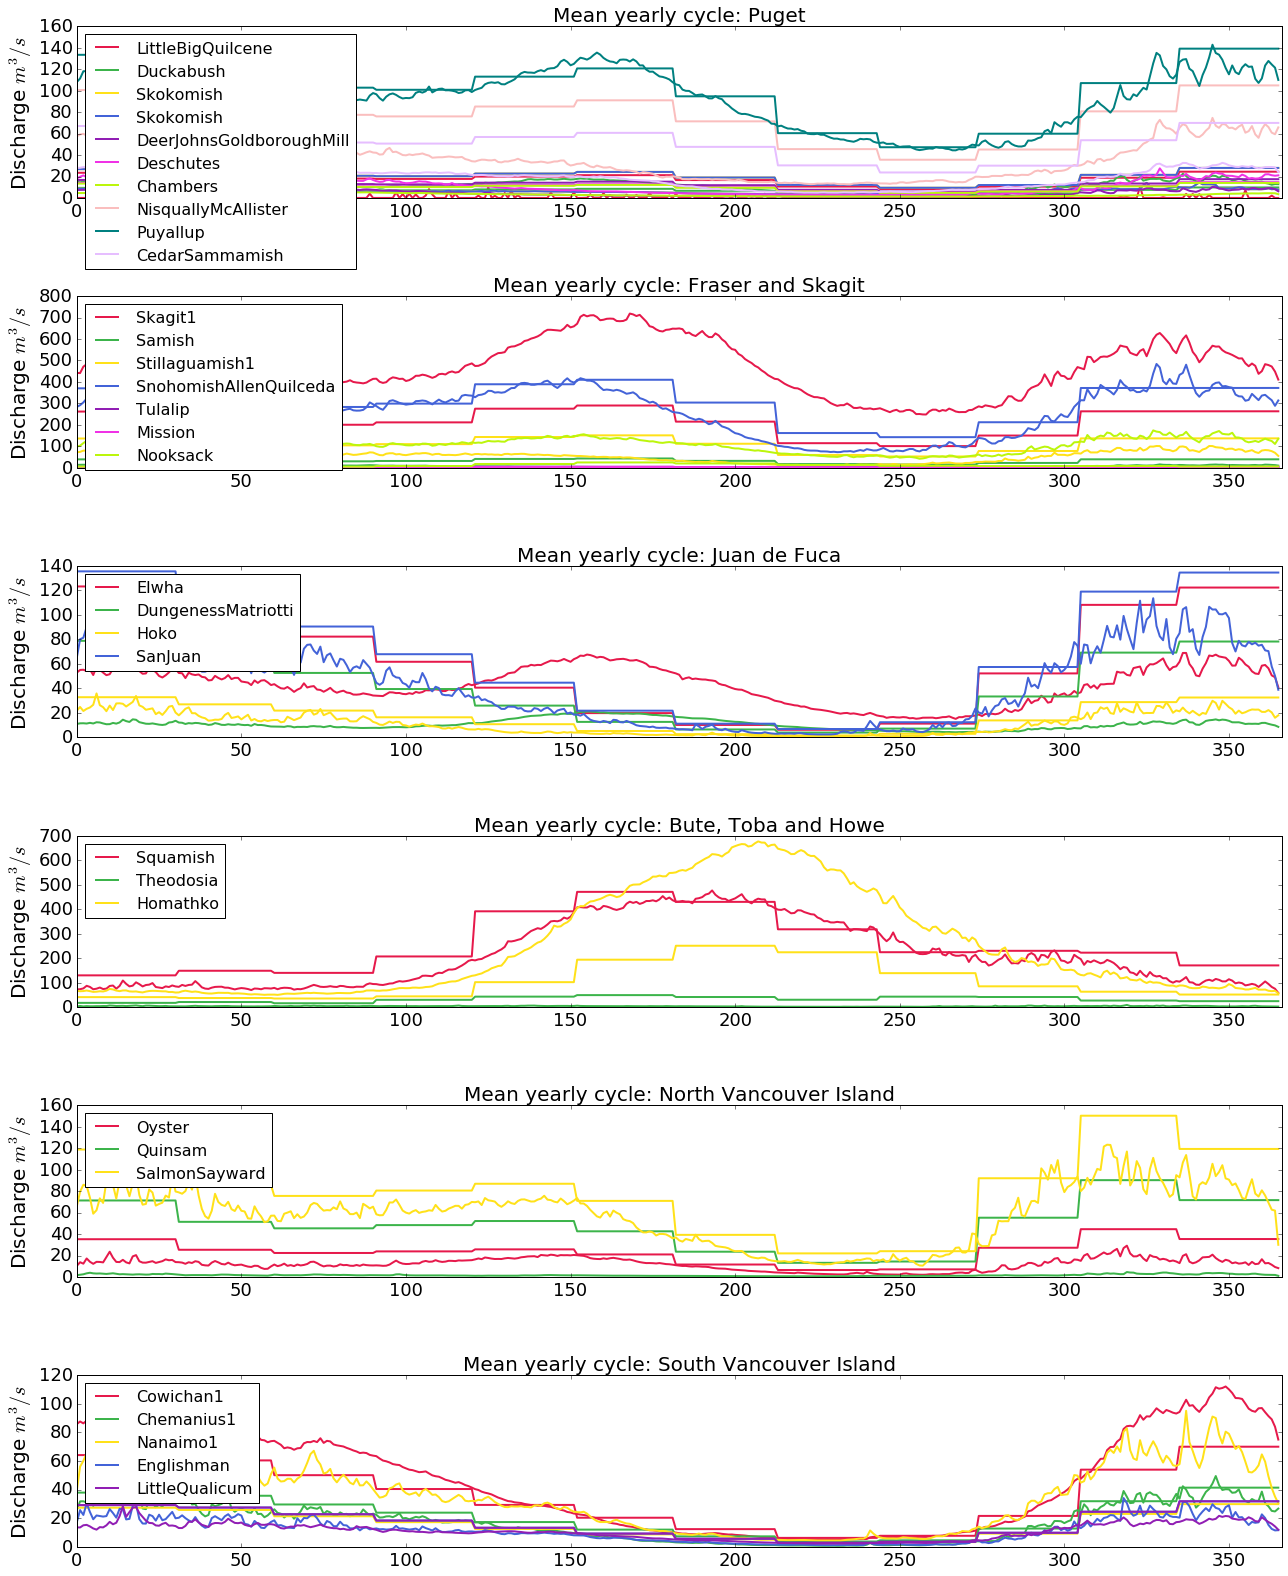

In [15]:
yearly = np.arange(0,366,1)
#code for mean yearly cycles
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,22))

for i in range(1,7):
    ax = fig.add_subplot(6,1,i)


    #puget
    if i == 1:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if twat == 'puget':
                tnam = (all_nam[r])
                if tnam == 'Skokomish2':
                    tnam = 'Skokomish'
                tdisk = riv_yearlys[tnam]
                mod_disk = riv_runoff_m3[tnam]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                ax.plot(yearly, mod_disk, color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Puget", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])

    if i == 2:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'fraser') | (twat == 'skagit')):
                tnam = (all_nam[r])
                if tnam == 'Skokomish2':
                    tnam = 'Skokomish'
                tdisk = riv_yearlys[tnam]
                mod_disk = riv_runoff_m3[tnam]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                ax.plot(yearly, mod_disk, color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Fraser and Skagit", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])        

    if i ==3:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'jdf')):
                tnam = (all_nam[r])
                if tnam == 'Skokomish2':
                    tnam = 'Skokomish'
                tdisk = riv_yearlys[tnam]
                mod_disk = riv_runoff_m3[tnam]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                ax.plot(yearly, mod_disk, color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Juan de Fuca", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])          

    if i ==4:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'bute') | (twat == 'toba') | (twat == 'howe')):
                tnam = (all_nam[r])
                if tnam == 'Skokomish2':
                    tnam = 'Skokomish'
                tdisk = riv_yearlys[tnam]
                mod_disk = riv_runoff_m3[tnam]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                ax.plot(yearly, mod_disk, color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Bute, Toba and Howe", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])   

    if i ==5:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'evi_n')):
                tnam = (all_nam[r])
                print(tnam)
                tnam2 = tnam
                if tnam == 'Quinsam' :
                    tnam2 = 'Qunisam'
                tdisk = riv_yearlys[tnam]
                mod_disk = riv_runoff_m3[tnam2]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                ax.plot(yearly, mod_disk, color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: North Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366]) 
        
    if i ==6:
        colcount = 0
        for r in range(0,len(all_nam)):
            twat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == 'evi_s')):
                tnam = (all_nam[r])
                if tnam == 'Skokomish2':
                    tnam = 'Skokomish'
                tdisk = riv_yearlys[tnam]
                mod_disk = riv_runoff_m3[tnam]
                
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount],linewidth = 2)
                ax.plot(yearly, mod_disk, color=cols2[colcount],linewidth = 2)
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: South Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366]) 
    #plt.legend(bbox_to_anchor=(1.1, 1.96))

plt.savefig('yearlycycle.jpg')
fig.tight_layout()  
#plt.show()

## [E] changes in said rivers (dashed line is 1962-1967, solid is 2012-2017)

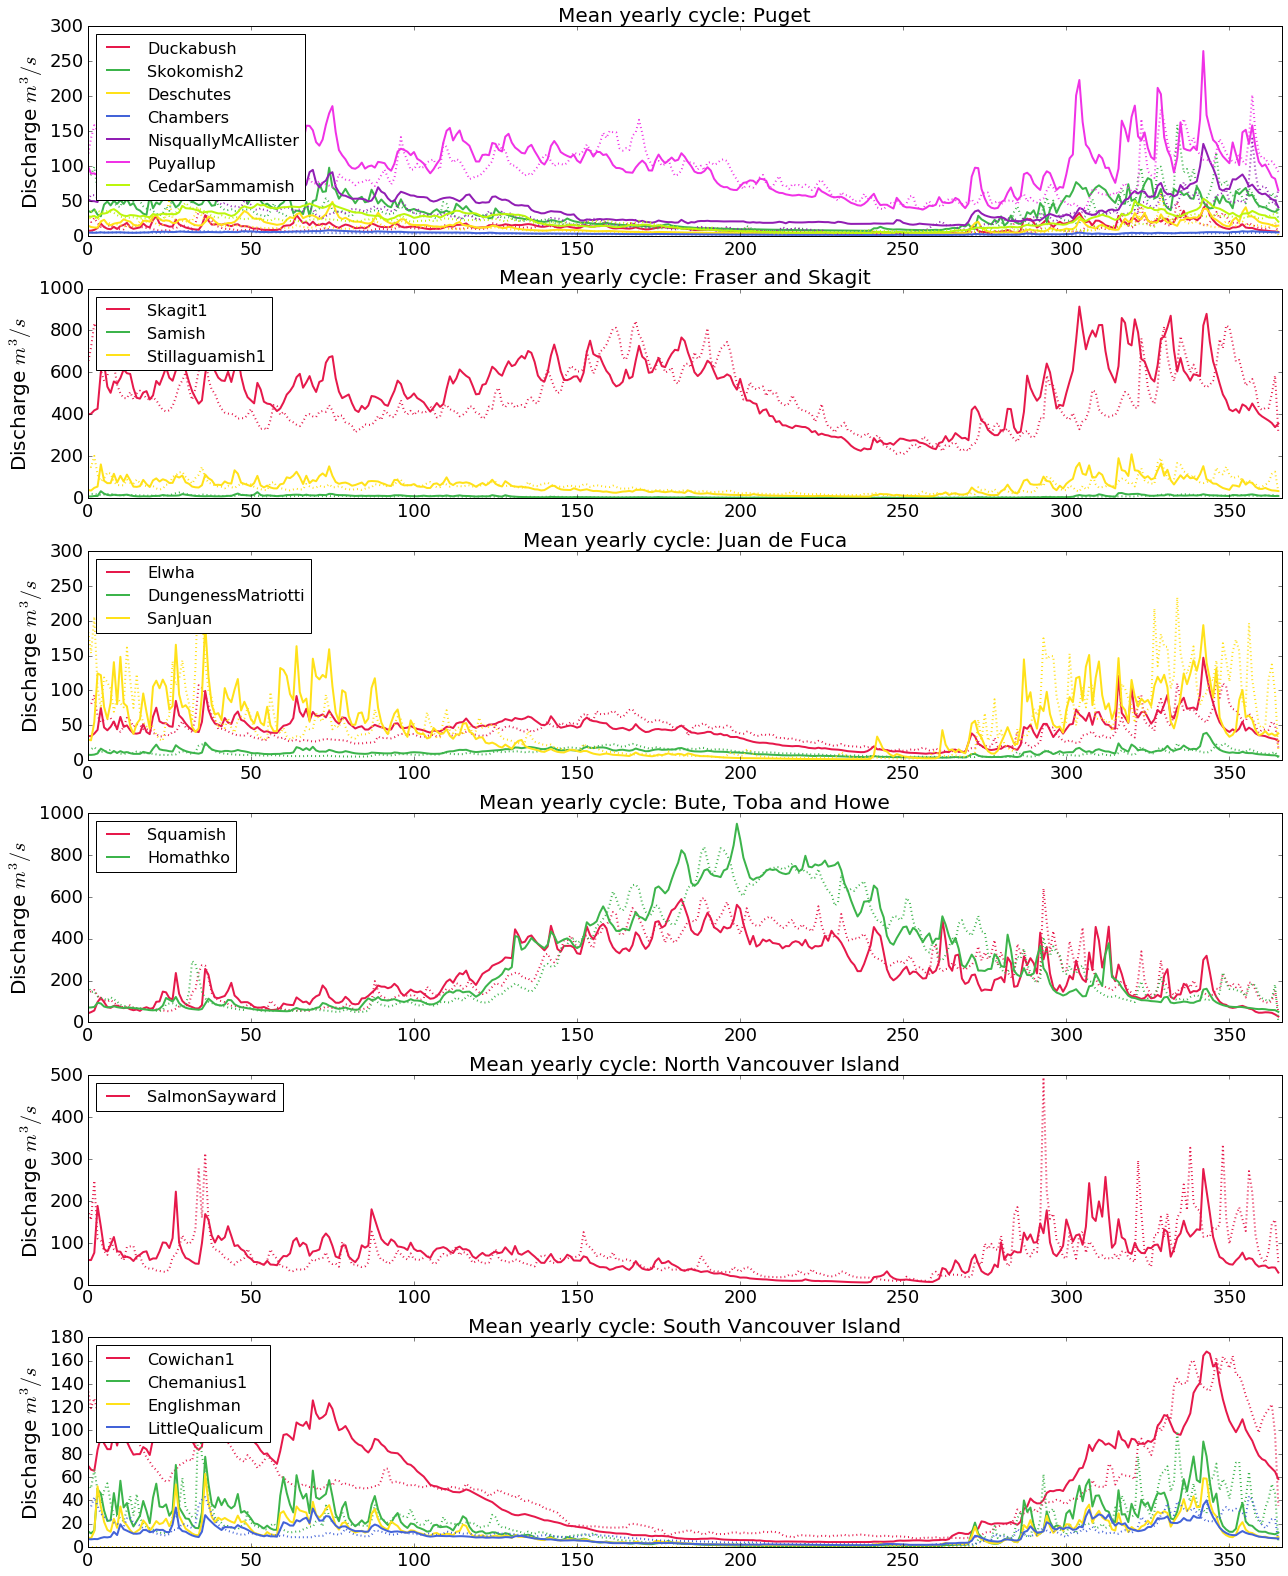

In [16]:
#code for mean yearly cycles
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,22))

for i in range(1,7):
    ax = fig.add_subplot(6,1,i)


    #puget
    if i == 1:
        colcount = 0
        for r in range(0,len(rivs_with_hist)):
            twat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if twat == 'puget':
                tnam = (rivs_with_hist[r])
                tdisk = riv_yearlys2012[tnam]
                tdiske = riv_yearlys1962[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount], linewidth = 2, linestyle = 'solid')
                ax.plot(yearly, tdiske, color=cols2[colcount], linewidth = 2, linestyle = 'dotted')
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Puget", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])

    if i == 2:
        colcount = 0
        for r in range(0,len(rivs_with_hist)):
            twat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if ((twat == 'fraser') | (twat == 'skagit')):
                tnam = (rivs_with_hist[r])
                tdisk = riv_yearlys2012[tnam]
                tdiske = riv_yearlys1962[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount], linewidth = 2, linestyle = 'solid')
                ax.plot(yearly, tdiske, color=cols2[colcount], linewidth = 2, linestyle = 'dotted')
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Fraser and Skagit", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])        

    if i ==3:
        colcount = 0
        for r in range(0,len(rivs_with_hist)):
            twat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if ((twat == 'jdf')):
                tnam = (rivs_with_hist[r])
                tdisk = riv_yearlys2012[tnam]
                tdiske = riv_yearlys1962[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount], linewidth = 2, linestyle = 'solid')
                ax.plot(yearly, tdiske,color=cols2[colcount], linewidth = 2, linestyle = 'dotted')
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Juan de Fuca", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])          

    if i ==4:
        colcount = 0
        for r in range(0,len(rivs_with_hist)):
            twat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if ((twat == 'bute') | (twat == 'toba') | (twat == 'howe')):
                tnam = (rivs_with_hist[r])
                tdisk = riv_yearlys2012[tnam]
                tdiske = riv_yearlys1962[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount], linewidth = 2, linestyle = 'solid')
                ax.plot(yearly, tdiske, color=cols2[colcount], linewidth = 2, linestyle = 'dotted')
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: Bute, Toba and Howe", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])   

    if i ==5:
        colcount = 0
        for r in range(0,len(rivs_with_hist)):
            twat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if ((twat == 'evi_n')):
                tnam = (rivs_with_hist[r])
                tdisk = riv_yearlys2012[tnam]
                tdiske = riv_yearlys1962[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount], linewidth = 2, linestyle = 'solid')
                ax.plot(yearly, tdiske, color=cols2[colcount], linewidth = 2, linestyle = 'dotted')
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: North Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366]) 
        
    if i ==6:
        colcount = 0
        for r in range(0,len(rivs_with_hist)):
            twat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if ((twat == 'evi_s')):
                tnam = (rivs_with_hist[r])
                tdisk = riv_yearlys2012[tnam]
                tdiske = riv_yearlys1962[tnam]
                ax.plot(yearly, tdisk, label = tnam,color=cols2[colcount], linewidth = 2, linestyle = 'solid')
                ax.plot(yearly, tdiske, color=cols2[colcount], linewidth = 2, linestyle = 'dotted')
                colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle: South Vancouver Island", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366]) 
    #plt.legend(bbox_to_anchor=(1.1, 1.96))

plt.savefig('evolveyearlycycle.jpg')
fig.tight_layout()  
#plt.show()2012

In [17]:
watersheds

dict_keys(['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s'])

In [18]:
wat_yearlys = {}

watersheds = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']


for w in range(0,len(watersheds)):
    twat = (watersheds[w])
#     print(twat)
    t_yearly = np.zeros([1,366])
    t_yearly1962 = np.zeros([1,366])
    t_yearly2012 = np.zeros([1,366])
    for r in range(0,len(all_nam)):
            mywat = riv_meta.loc[riv_meta.River == all_nam[r],['Watershed']].values
            if ((twat == mywat)):
#                 print(all_nam[r])
                t_yearly = t_yearly + riv_yearlys[all_nam[r]]

    wat_yearlys[twat] = t_yearly

    
   
wat_yearlys1962 = {}
wat_yearlys2012 = {}

for w in range(0,len(watersheds)):
    twat = (watersheds[w])
#     print(twat)
    t_yearly = np.zeros([1,366])
    t_yearly1962 = np.zeros([1,366])
    t_yearly2012 = np.zeros([1,366])
    for r in range(0,len(rivs_with_hist)):
            mywat = riv_meta.loc[riv_meta.River == rivs_with_hist[r],['Watershed']].values
            if ((twat == mywat)):
                #print(rivs_with_hist[r])
                t_yearly1962 = t_yearly1962 + riv_yearlys1962[rivs_with_hist[r]]
                t_yearly2012 = t_yearly2012 + riv_yearlys2012[rivs_with_hist[r]]

    wat_yearlys1962[twat] = t_yearly1962
    wat_yearlys2012[twat] = t_yearly2012

#     wat_yearlys1962[twat] = t_yearly1962
#     wat_yearlys2012[twat] = t_yearly2012
#     print(' ')


## [F] Measured yearly cycle - by watershed (only gauged rivers, of course...)

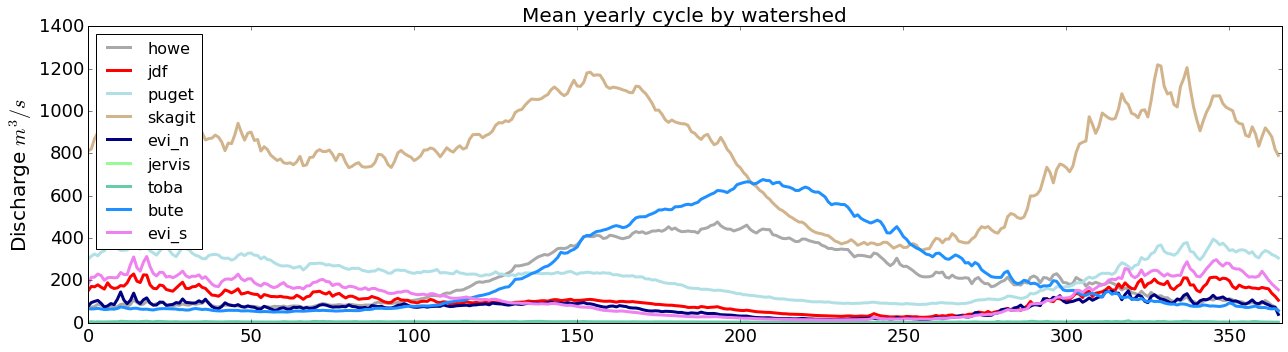

In [19]:
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,5))

for i in range(1,2):
    ax = fig.add_subplot(1,1,i)


    #puget
    if i == 1:
        colcount = 0
        for w in range(0,len(watersheds)):
            tnam = watersheds[w]
            if tnam != 'fraser':
                tdisk = wat_yearlys[tnam]
                tdisk2 = np.squeeze(tdisk)
                ax.plot(yearly, tdisk2, label = tnam,color=cols[colcount],linewidth = 3)
            colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle by watershed", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])
        
plt.savefig('wshedyearlycycle.jpg')
fig.tight_layout()

# [G] watershed discharge changes

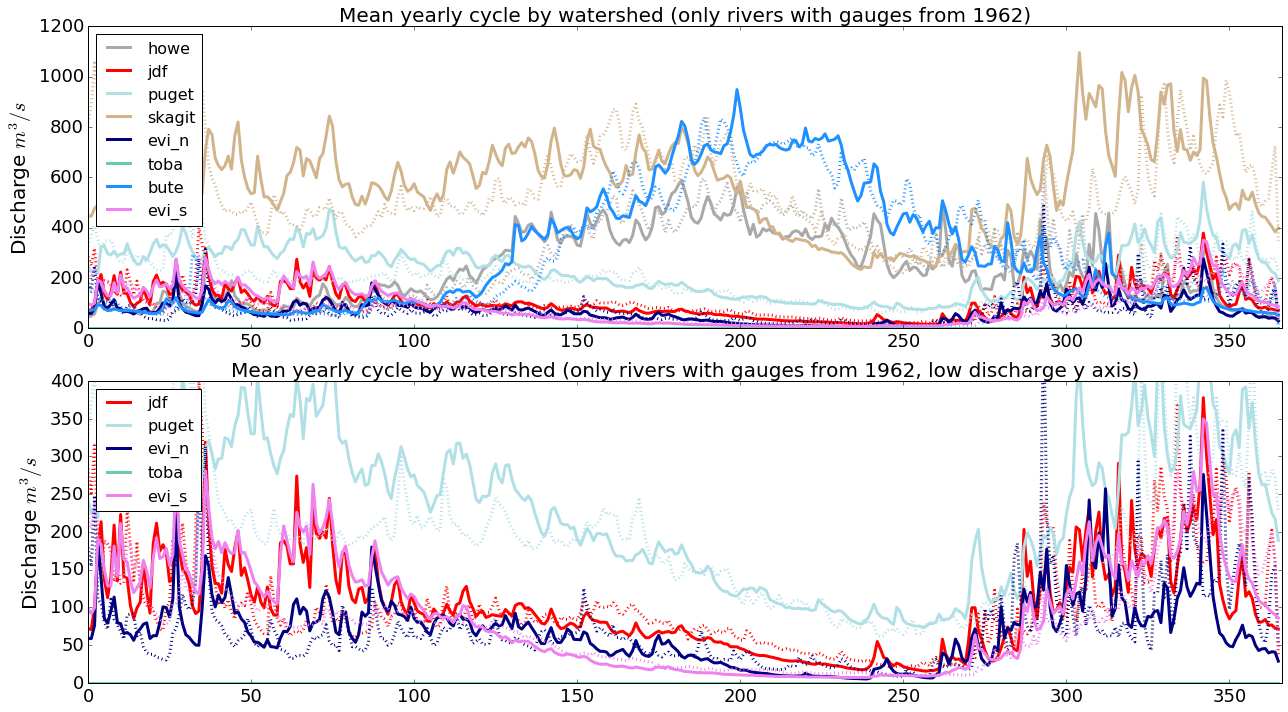

In [20]:
monr = np.arange(1,13,1)
fig = plt.figure(figsize=(18,10))

for i in range(1,3):
    ax = fig.add_subplot(2,1,i)


    #puget
    if i == 1:
        colcount = 0
        for w in range(0,len(watersheds)):
            tnam = watersheds[w]
            if (tnam != 'fraser') & (tnam != 'jervis') :
                tdisk = wat_yearlys2012[tnam]
                tdisk2 = np.squeeze(tdisk)
                ax.plot(yearly, tdisk2, label = tnam,color=cols[colcount],linewidth = 3)
                tdisk3 = wat_yearlys1962[tnam]
                tdisk4 = np.squeeze(tdisk3)
                ax.plot(yearly, tdisk4, color=cols[colcount],linewidth = 3, linestyle = 'dotted')
            colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle by watershed (only rivers with gauges from 1962)", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])
        
    if i == 2:
        colcount = 0
        for w in range(0,len(watersheds)):
            tnam = watersheds[w]
            if (tnam != 'fraser') & (tnam != 'skagit') & (tnam != 'bute') & (tnam != 'howe') & (tnam != 'jervis'):
                tdisk = wat_yearlys2012[tnam]
                tdisk2 = np.squeeze(tdisk)
                ax.plot(yearly, tdisk2, label = tnam,color=cols[colcount],linewidth = 3)
                tdisk3 = wat_yearlys1962[tnam]
                tdisk4 = np.squeeze(tdisk3)
                ax.plot(yearly, tdisk4, color=cols[colcount],linewidth = 3, linestyle = 'dotted')
            colcount = colcount+1

        ax.legend(loc="upper left", fontsize = 16 )
        ax.set_title("Mean yearly cycle by watershed (only rivers with gauges from 1962, low discharge y axis)", fontsize = 20 )  
        ax.set_ylabel('Discharge $m{^3}/s$', fontsize=20)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.set_xlim([0, 366])
        ax.set_ylim([0,400])
        
plt.savefig('wshedevolveyearlycycle.jpg')
fig.tight_layout()

# [H] Squamish and other river changes

<class 'list'>
1963
1968
1973
1978
1983
1988
1993
1998
2003
2008
2013
1963
1968
1973
1978
1983
1988
1993
1998
2003
2008
2013


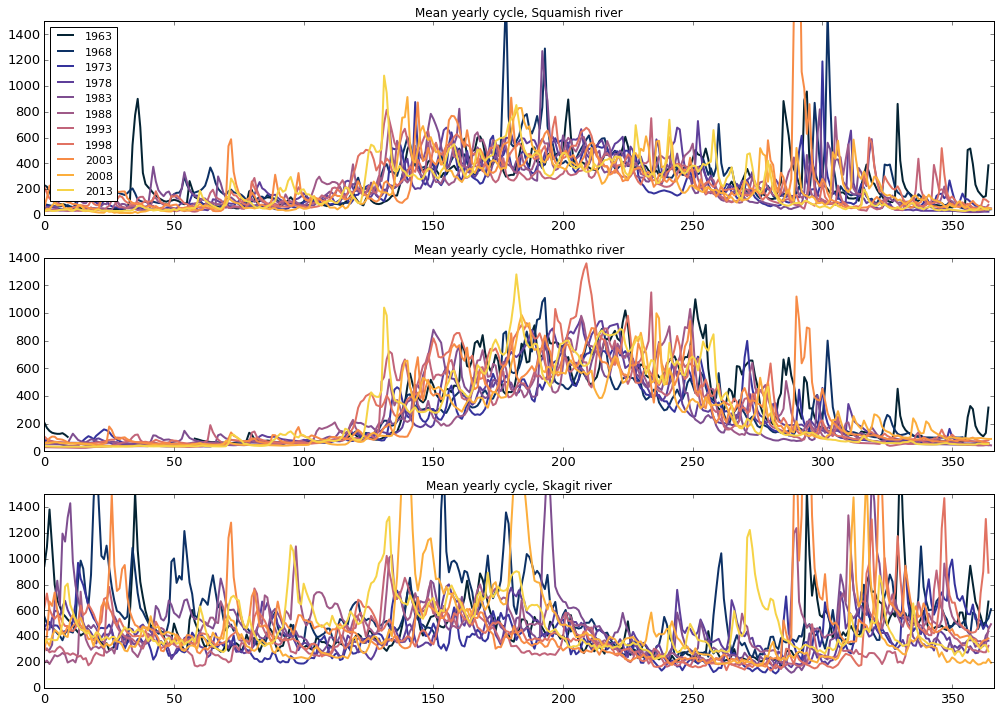

In [21]:
tdate, tdisk = extract_dates_disc_CAN('Squamish')

print(type(tdate))
test = dt.datetime(1964,1,1)
# find(tdate == dt.datetime(1964,1,1))

cmap = cm.thermal  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

    
    
fig = plt.figure(figsize=(14,10))
for i in range(1,4):
    ax = fig.add_subplot(3,1,i)


    #squamish
    if i == 1:
        tdate, tdisk = extract_dates_disc_CAN('Squamish')
        for yr in range(1963,2018,5):
            print(yr)
            tyear = np.zeros([1,366])
            yrlab = str(yr)
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-1963) /(2018-1963) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )
        ax.set_title('Mean yearly cycle, Squamish river')
        ax.set_ylim([0,1500])
        ax.set_xlim([0,366])
        ax.legend(loc="upper left", fontsize = 11 )
        
        
    if i == 2:
        tdate, tdisk = extract_dates_disc_CAN('Homathko')
        for yr in range(1963,2018,5):
            #print(yr)
            tyear = np.zeros([1,366])
            yrlab = str(yr)
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-1963) /(2018-1963) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )
        ax.set_title('Mean yearly cycle, Homathko river')
        #ax.set_ylim([0,1500])
        ax.set_xlim([0,366])
#         ax.legend(loc="upper left", fontsize = 16 )
        
    if i == 3:
        tdate, tdisk = extract_dates_disc_US('Skagit1')
        for yr in range(1963,2018,5):
            #print(yr)
            tyear = np.zeros([1,366])
            yrlab = str(yr)
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-1963) /(2018-1963) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )
        ax.set_title('Mean yearly cycle, Skagit river')
        ax.set_ylim([0,1500])
        ax.set_xlim([0,366])
#         ax.legend(loc="upper left", fontsize = 16 )

plt.savefig('select-rivers_yearly.jpg')
fig.tight_layout()

<class 'list'>


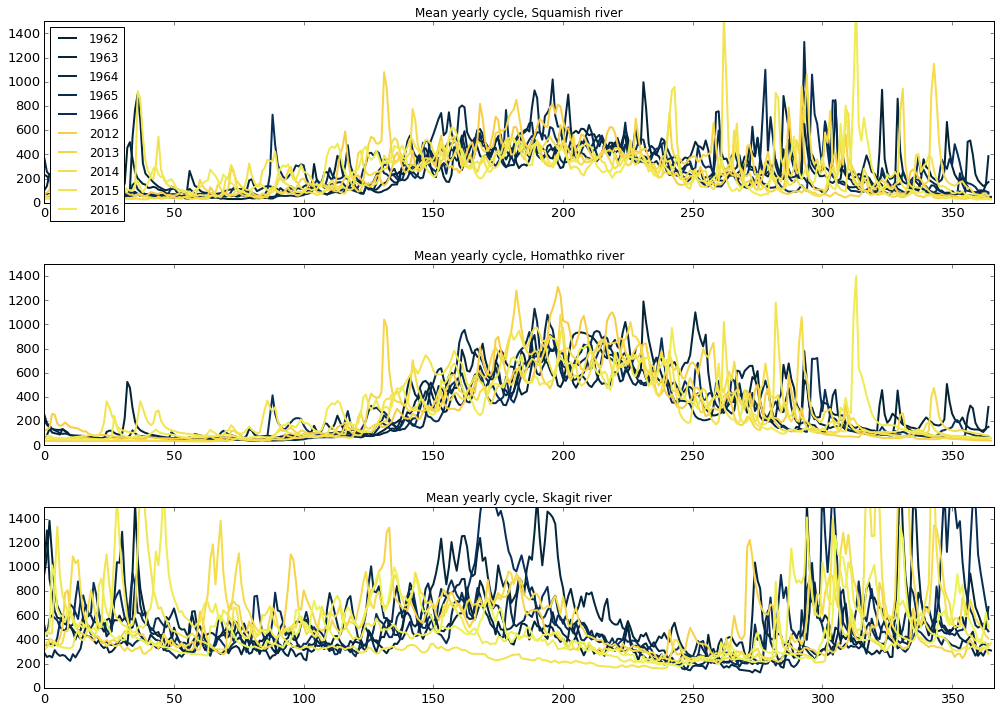

In [22]:
estart = 1962
eend = 1967
lstart = 2012
lend = 2017
tdate, tdisk = extract_dates_disc_CAN('Squamish')
print(type(tdate))
test = dt.datetime(1964,1,1)
# find(tdate == dt.datetime(1964,1,1))

cmap = cm.thermal  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

    
    
fig = plt.figure(figsize=(14,10))
for i in range(1,4):
    ax = fig.add_subplot(3,1,i)

    #squamish
    if i == 1:
        tdate, tdisk = extract_dates_disc_CAN('Squamish')
        
        earlymean = np.zeros([5,366])
        counter = 0 
        
        for yr in range(estart,eend):
            tyear = np.zeros([1,366])
            
            yrlab = str(yr)
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-estart) /(2018-estart) * 256)
            earlymean[counter,:] = tyear2
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )
        earlymean[earlymean==0] = np.nan
        emean = np.nanmean(earlymean, axis=0)
        #ax.plot(yearly,emean,color = 'dodgerblue',label = 'early mean', linewidth = 3 )
        
        latemean = np.zeros([5,366])
        counter=0
        
        for yr in range(lstart,lend):
            tyear = np.zeros([1,366])
            yrlab = str(yr)
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            if yr == 2017:
                tine = len(tdate)-1
            if yr != 2017:
                tine= (tdate.index(dt.datetime(yr+1,1,1)))
            

            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-estart) /(2018-estart) * 256)
            latemean[counter,:] = tyear2
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )        

        latemean[latemean==0] = np.nan
        emean = np.nanmean(latemean, axis=0)
        #ax.plot(yearly,emean,color = 'goldenrod',label = 'late mean', linewidth = 3 )
            
        ax.set_title('Mean yearly cycle, Squamish river')
        ax.set_ylim([0,1500])
        ax.set_xlim([0,366])
        ax.legend(loc="upper left", fontsize = 12 )
        
        
    #squamish
    if i == 2:
        tdate, tdisk = extract_dates_disc_CAN('Homathko')
        for yr in range(estart,eend):
            tyear = np.zeros([1,366])
            yrlab = str(yr)
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-estart) /(2018-estart) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )

        for yr in range(lstart,lend):
            tyear = np.zeros([1,366])
            yrlab = str(yr)
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            if yr == 2017:
                tine = len(tdate)-1
            if yr != 2017:
                tine= (tdate.index(dt.datetime(yr+1,1,1)))
            

            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-estart) /(2018-estart) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )        

        ax.set_title('Mean yearly cycle, Homathko river')
        ax.set_ylim([0,1500])
        ax.set_xlim([0,366])
        #ax.legend(loc="upper left", fontsize = 12 )
        
    #squamish
    if i == 3:
        tdate, tdisk = extract_dates_disc_US('Skagit1')
        for yr in range(1963,1968):
            tyear = np.zeros([1,366])
            yrlab = str(yr)
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-1963) /(2018-1963) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )

        for yr in range(2013,2018):
            tyear = np.zeros([1,366])
            yrlab = str(yr)
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            if yr == 2017:
                tine = len(tdate)-1
            if yr != 2017:
                tine= (tdate.index(dt.datetime(yr+1,1,1)))
            

            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-1963) /(2018-1963) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop],label = yrlab, linewidth = 2 )        

        ax.set_title('Mean yearly cycle, Skagit river')
        ax.set_ylim([0,1500])
        ax.set_xlim([0,366])
        #ax.legend(loc="upper left", fontsize = 12 )
        
#plt.savefig('select-rivers_thenandnow.jpg')
fig.tight_layout()

<class 'list'>


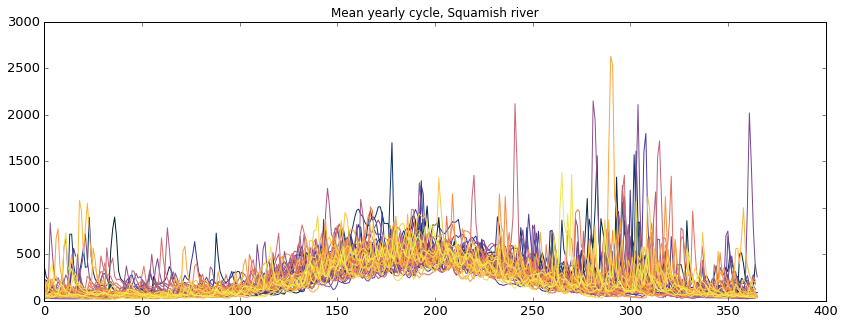

In [23]:
tdate, tdisk = extract_dates_disc_CAN('Squamish')

print(type(tdate))
test = dt.datetime(1964,1,1)
# find(tdate == dt.datetime(1964,1,1))

cmap = cm.thermal  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

    
    
fig = plt.figure(figsize=(14,5))
for i in range(1,2):
    ax = fig.add_subplot(1,1,i)


    #puget
    if i == 1:
        for yr in range(1963,2013):
            tyear = np.zeros([1,366])
        
            tins = (tdate.index(dt.datetime(yr,1,1)))
            tine = (tdate.index(dt.datetime(yr+1,1,1)))
            for d in range(tins,tine):
                trial = tdate[d]
                doy = trial.timetuple().tm_yday
                tyear[0,doy-1] = tdisk[d]
            tyear[tyear==0] = np.nan
            tyear2 = np.squeeze(tyear)
            yrprop = int((yr-1963) /(2013-1963) * 256)
            ax.plot(yearly,tyear2,color = cmaplist[yrprop] )
        ax.set_title('Mean yearly cycle, Squamish river')
